# GFlowNet High Mean Vertex Degree Graph Generation Tutorial

This tutorial demonstrates how to train a GFlowNet to generate graphs with high Mean Vertex Degree (MVD) - where we aim to create densely connected graphs by maximizing the average number of edges connected to each vertex.


## Setup

Let's first import all the necessary libraries:

In [1]:
import math
import time

import matplotlib.pyplot as plt
import torch
from matplotlib import patches

from gfn.containers import ReplayBuffer
from gfn.gflownet.trajectory_balance import TBGFlowNet
from gfn.gym.graph_building import GraphBuildingOnEdges
from gfn.modules import DiscreteGraphPolicyEstimator
from gfn.states import GraphStates
from gfn.utils.modules import GraphEdgeActionGNN

torch.random.manual_seed(7)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/home/oyounis-iit.local/anaconda3/envs/torchgfn/lib/python3.11/site-packages/torch/__config__.py:10: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._show_config()


## Defining the Reward Function

A crucial component of GFlowNet training is the reward function. In this tutorial, we aim to sample graphs with high Mean Vertex Degree (MVD). The MVD is a measure of how densely connected a graph is - it's calculated as the average number of edges connected to each vertex. A higher MVD indicates a more densely connected graph.

For example:
- In a fully connected graph with n vertices, each vertex has degree (n-1), so MVD = n-1
- In a sparse graph where each vertex connects to just one other vertex, MVD = 1
- In a ring graph, each vertex has exactly two neighbors, so MVD = 2

We define here the function computing the reward based on MVD:

In [2]:
def mvd_function(states: GraphStates) -> torch.Tensor:
    """Compute the Mean Vertex Degree (MVD) of the graphs.

    This function evaluates the Mean Vertex Degree of each graph in the batch.
    MVD is calculated as the average number of edges connected to each vertex.
    Higher MVD means the graph is more densely connected.

    Args:
        states: A batch of graph states to evaluate

    Returns:
        A tensor of rewards with the same batch shape as states
    """

    out = torch.zeros((len(states),))
    if states.tensor.edge_index.numel() == 0:
        return out

    for i in range(len(states)):
        graph = states[i]
        if graph.tensor.num_nodes == 0:
            continue

        # Create adjacency matrix
        adj_matrix = torch.zeros(graph.tensor.num_nodes, graph.tensor.num_nodes)
        adj_matrix[graph.tensor.edge_index[0], graph.tensor.edge_index[1]] = 1
        adj_matrix[graph.tensor.edge_index[1], graph.tensor.edge_index[0]] = 1

        # Calculate vertex degrees
        vertex_degrees = adj_matrix.sum(dim=1)
        
        # Calculate mean vertex degree
        out[i] = vertex_degrees.mean()

    return out.view(*states.batch_shape)


def reward_function(states: GraphStates) -> torch.Tensor:
    """Compute reward based on Mean Vertex Degree (MVD) of the graphs.

    This function evaluates the Mean Vertex Degree of each graph in the batch.
    MVD is calculated as the average number of edges connected to each vertex.

    """
    return torch.exp(mvd_function(states))

## Visualization Function

To understand what the model is generating and visualize the density of connections, we need a visualization function:

In [3]:
def render_states(states: GraphStates):
    """Visualize a batch of graph states as ring structures.

    This function creates a matplotlib visualization of graph states, rendering them
    as circular layouts with nodes positioned evenly around a circle.

    The visualization includes:
    - Circular positioning of nodes
    - Drawing edges between connected nodes
    - Displaying the reward value for each graph

    Args:
        states: A batch of graphs to visualize
        state_evaluator: Function to compute rewards for each graph
    """
    mvds = mvd_function(states)
    fig, ax = plt.subplots(2, 4, figsize=(15, 7))
    for i in range(8):
        current_ax = ax[i // 4, i % 4]
        state = states[i]
        n_circles = state.tensor.num_nodes
        radius = 5
        xs, ys = [], []
        for j in range(n_circles):
            angle = 2 * math.pi * j / n_circles
            x = radius * math.cos(angle)
            y = radius * math.sin(angle)
            xs.append(x)
            ys.append(y)
            current_ax.add_patch(
                patches.Circle((x, y), 0.5, facecolor="none", edgecolor="black")
            )

        edge_index = states[i].tensor.edge_index

        for edge in edge_index.T:
            start_x, start_y = xs[edge[0]], ys[edge[0]]
            end_x, end_y = xs[edge[1]], ys[edge[1]]
            dx = end_x - start_x
            dy = end_y - start_y
            length = math.sqrt(dx**2 + dy**2)
            dx, dy = dx / length, dy / length

            circle_radius = 0.5

            start_x += dx * circle_radius
            start_y += dy * circle_radius
            end_x -= dx * circle_radius
            end_y -= dy * circle_radius
            current_ax.plot([start_x, end_x], [start_y, end_y], color="black")

        current_ax.set_title(f"State {i}, MVD={mvds[i]:.2f}")
        current_ax.set_xlim(-(radius + 1), radius + 1)
        current_ax.set_ylim(-(radius + 1), radius + 1)
        current_ax.set_aspect("equal")
        current_ax.set_xticks([])
        current_ax.set_yticks([])

    plt.show()

## Environment and policy estimator 

Let's define the environment using our MVD-based reward function. The action space for the GraphBuildingOnEdges is discrete, so we will also define the DiscretePolicyEstimator for it. As typical with GFlowNets, we will have two policies, one for the forward step and one for backward.

In [4]:
directed = False
env = GraphBuildingOnEdges(
    n_nodes=5,
    state_evaluator=reward_function,
    directed=directed,
    device=device,
)


pf = DiscreteGraphPolicyEstimator(
    module=GraphEdgeActionGNN(
        env.n_nodes,
        directed=directed,
        num_edge_classes=env.num_edge_classes,
        embedding_dim=16,
    )
)
pb = DiscreteGraphPolicyEstimator(
    module=GraphEdgeActionGNN(
        env.n_nodes,
        directed=directed,
        is_backward=True,
        num_edge_classes=env.num_edge_classes,
        embedding_dim=16,
    ),
    is_backward=True,
)

gflownet = TBGFlowNet(pf, pb).to(device)

## Sampling before training

Let's sample the graphs using the untrained policy to see the initial distribution.

/home/oyounis-iit.local/anaconda3/envs/torchgfn/lib/python3.11/site-packages/torch/distributions/distribution.py:56: UserWarning: <class 'gfn.utils.distributions.GraphActionDistribution'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


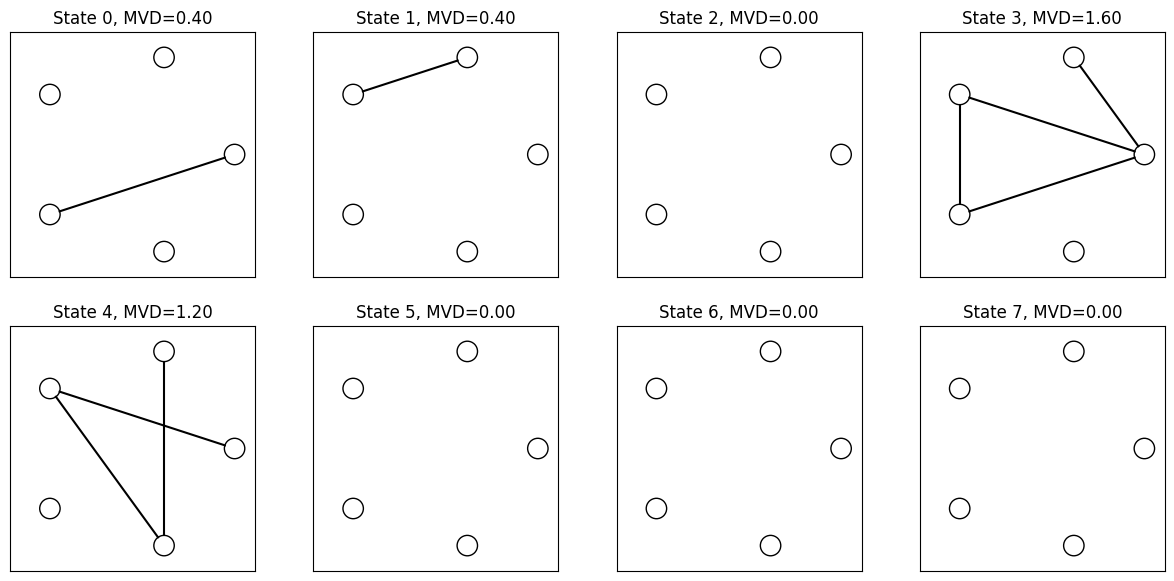

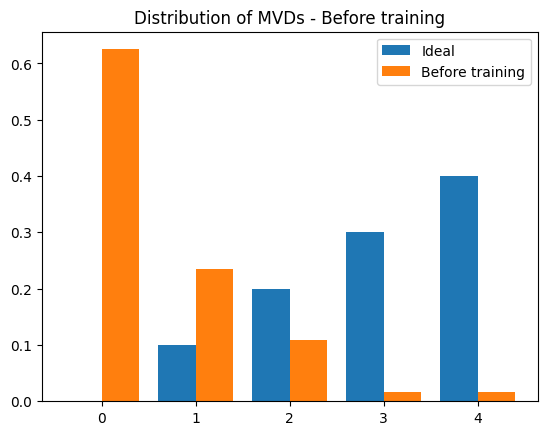

In [5]:
trajectories = gflownet.sample_trajectories(env, n=64)
terminating_states = trajectories.terminating_states
render_states(terminating_states[:8])  # type: ignore


ideal_distribution = torch.arange(env.n_nodes)
ideal_distribution = ideal_distribution / ideal_distribution.sum()

# Distribution of MVDs
mvds_before = mvd_function(terminating_states)  # type: ignore
mvds_before = torch.round(mvds_before).int()
mvd_counts_before = torch.zeros(env.n_nodes, dtype=torch.int32)
for mvd in mvds_before:
    mvd_counts_before[mvd] += 1
mvd_counts_before = mvd_counts_before / mvd_counts_before.sum()


plt.title("Distribution of MVDs - Before training")
plt.bar(torch.arange(env.n_nodes) - 0.2, ideal_distribution.cpu().numpy(), label='Ideal', width=0.4)
plt.bar(torch.arange(env.n_nodes) + 0.2, mvd_counts_before.cpu().numpy(), label='Before training', width=0.4)
plt.legend()
plt.show()


## Training

Let's write a training loop with Trajectory-Based GFlowNets, and using a ReplayBuffer. The model will learn to generate graphs that maximize the Mean Vertex Degree.


In [ ]:
lr = 1e-4
batch_size = 32
n_iterations = 500

optimizer = torch.optim.Adam(gflownet.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

replay_buffer = ReplayBuffer(
    env,
    capacity=batch_size,
    prioritized=True,
)

losses = []

print(f"Starting training on {device} device...")

t1 = time.time()
for iteration in range(n_iterations):
    trajectories = gflownet.sample_trajectories(
        env,
        n=batch_size,
        save_logprobs=True,
    )
    training_samples = gflownet.to_training_samples(trajectories)

    # Collect rewards for reporting.
    terminating_states = training_samples.terminating_states
    assert isinstance(terminating_states, GraphStates)

    optimizer.zero_grad()
    loss = gflownet.loss(env, training_samples, recalculate_all_logprobs=True)
    mean_mvd = mvd_function(terminating_states).mean()
    
    if iteration % 10 == 0:
        print(
            "Iteration {} - Loss: {:.02f}, MVD: {:.02f}".format(
                iteration, loss.item(), mean_mvd
            )
        )
        
    loss.backward()
    optimizer.step()
    scheduler.step()
    losses.append(loss.item())

t2 = time.time()
print(f"Training completed in {t2 - t1:.2f} seconds")



Starting training on cpu device...


/home/oyounis-iit.local/VSCode/torchgfn-1/src/gfn/utils/handlers.py:53: UserWarning: Recalculating logprobs for a container that already has them. This might be intended, if the log_probs were calculated off-policy.However, this is inefficient when training on-policy. In this case, you should instead call loss() or loss_from_trajectories() with recalculate_all_logprobs=False 
  warnings.warn(


Iteration 0 - Loss: 55.46, MVD: 0.63
Iteration 10 - Loss: 49.25, MVD: 0.60
Iteration 20 - Loss: 44.95, MVD: 0.50


## Sampling from Trained Models

We can use our trained models to generate graphs with high Mean Vertex Degree, and visualize them:

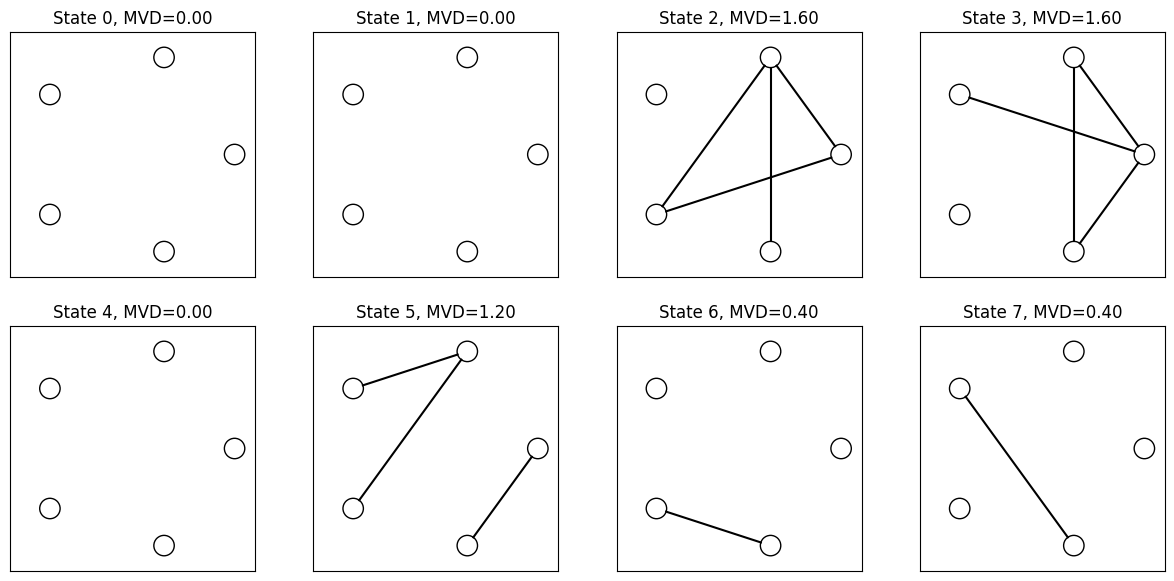

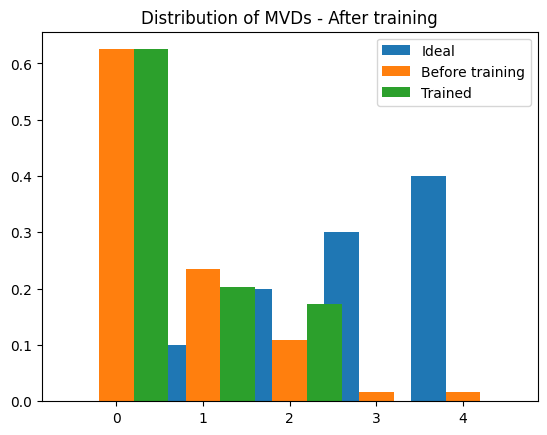

In [7]:
trajectories = gflownet.sample_trajectories(env, n=64)
terminating_states = trajectories.terminating_states
render_states(terminating_states[:8])  # type: ignore


# Distribution of MVDs
mvds = mvd_function(terminating_states)  # type: ignore
mvds = torch.round(mvds).int()
mvd_counts = torch.zeros(env.n_nodes, dtype=torch.int32)
for mvd in mvds:
    mvd_counts[mvd] += 1
mvd_counts = mvd_counts / mvd_counts.sum()

plt.title("Distribution of MVDs - After training")
plt.bar(torch.arange(env.n_nodes) - 0.4, ideal_distribution.cpu().numpy(), label='Ideal', width=0.3)
plt.bar(torch.arange(env.n_nodes), mvd_counts_before.cpu().numpy(), label='Before training', width=0.3)
plt.bar(torch.arange(env.n_nodes) + 0.4, mvd_counts.cpu().numpy(), label='Trained', width=0.3)
plt.legend()
plt.show()

## Conclusion

In this tutorial, we explored how to train a GFlowNet to generate graphs with high Mean Vertex Degree (MVD).

GFlowNets provide a powerful framework for learning to generate graphs with desired properties by defining utility through reward functions; higher rewards correspond to higher utility. While we focused on generating densely connected graphs in this example, GFlowNets can be readily adapted to generate diverse graph types with different connectivity patterns and structural properties. This flexibility makes GFlowNets particularly valuable for applications requiring structured data generation with specific objectives.